In [1]:
import numpy as np
import json
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import multiprocessing
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
import pickle
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow
from tensorflow.python.keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from keras.optimizers import Adam
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import pandas as pd
from matplotlib import pyplot as plt
import sys
from scipy import io
from scipy import stats
# gradient boosted trees tend to do well on problems like this

BIDS_path = 'C:\\Users\\ICN_admin\\Documents\\BIDS\\'
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
out_path = 'C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\'

def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

def create_model():
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes, input_shape=(40,), activation=activation
                   ))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(Dense(1,activation='linear'))

    #setup our optimizer and compile
    adam = Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='mean_squared_error',
                 metrics=['mse'])
    return model

space_NN = [Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate'),
              Integer(low=1, high=3, name='num_dense_layers'),
              Integer(low=1, high=10, prior='uniform', name='num_input_nodes'),
              Integer(low=1, high=10, name='num_dense_nodes'),
              Categorical(categories=['relu', 'tanh'], name='activation')
             ]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space_NN)
def objective(**params):
    print(params)

    global learning_rate
    learning_rate=params["learning_rate"]
    global num_dense_layers
    num_dense_layers=params["num_dense_layers"]
    global num_input_nodes
    num_input_nodes=params["num_input_nodes"]
    global num_dense_nodes
    num_dense_nodes=params["num_dense_nodes"]
    global activation
    activation=params["activation"]



    model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=300, verbose=0)

    cv_res = cross_val_score(model, X_time, y_time, cv=2, n_jobs=1, scoring="r2")

    #kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

    #cv_res = cross_val_score(reg, X_time, y_time, cv=3, n_jobs=-1,
    #                                scoring="r2")
    cv_res[np.where(cv_res < 0)[0]] = 0
    return -np.mean(cv_res)
    #return -cv_result['test-r2-mean'].iloc[-1]


Using TensorFlow backend.


In [2]:
def get_movement_idx(ch, mov_channels, Con=True):
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx

In [3]:
def get_x_y_c(dict_ch, ind_, Con=True, return_z=False):
    
    channels = list(dict_ch.keys())
    x_choord = np.zeros(len(ind_))
    y_choord = np.zeros(len(ind_))
    z_choord = np.zeros(len(ind_))
    c_ = np.zeros(len(ind_))
    for idx, ind_ch in enumerate(ind_): 
        choord = np.squeeze(np.array(dict_ch[channels[ind_ch]]["choords"]))
        x_choord[idx] = choord[0]
        y_choord[idx] = choord[1]
        z_choord[idx] = choord[2]
        
        #wähle den contralateralen channel aus
        #mov_channels = dict_ch[channels[ind_ch]]['mov_ch']

        #mov_idx = get_movement_idx(channels[ind_ch], mov_channels, Con)

        #c_[idx] = dict_ch[channels[ind_ch]]["res_"+mov_channels[mov_idx]]["R2"]
    #if return_z is True:
    #    return x_choord, y_choord, z_choord#, c_
    return x_choord, y_choord#, c_

In [4]:
def get_modalitities(XGB_res):
    ecog_con_RF = []; ecog_con_RF_P = []; 
    ecog_ips_RF = []; ecog_ips_RF_P = []
    stn_con_RF = []; stn_con_RF_P = []
    stn_ips_RF = []; stn_ips_RF_P = []
    for patient in subject_id:
        channels = list(XGB_res[patient].keys())
        patient_ecog_con = []; patient_ecog_ips = []; patient_stn_con = []; patient_stn_ips = []
        patient_ecog_con_P = []; patient_ecog_ips_P = []; patient_stn_con_P = []; patient_stn_ips_P = []
        for ch in channels:
            if 'ECOG' in ch:
                patient_ecog_con.append(XGB_res[patient][ch]["r2_con"])
                patient_ecog_ips.append(XGB_res[patient][ch]["r2_ips"])
                patient_ecog_con_P.append(XGB_res[patient][ch]["param_con"])
                patient_ecog_ips_P.append(XGB_res[patient][ch]["param_ips"])
            elif 'STN' in ch:
                patient_stn_con.append(XGB_res[patient][ch]["r2_con"])
                patient_stn_ips.append(XGB_res[patient][ch]["r2_ips"])
                patient_stn_con_P.append(XGB_res[patient][ch]["param_con"])
                patient_stn_ips_P.append(XGB_res[patient][ch]["param_ips"])
        
        max_arg = np.argmax(patient_ecog_con)
        ecog_con_RF.append(patient_ecog_con[max_arg])
        ecog_con_RF_P.append(patient_ecog_con_P[max_arg])
        
        max_arg = np.argmax(patient_ecog_ips)
        ecog_ips_RF.append(patient_ecog_ips[max_arg])
        ecog_ips_RF_P.append(patient_ecog_ips_P[max_arg])
        
        
        max_arg = np.argmax(patient_stn_con)
        stn_con_RF.append(patient_stn_con[max_arg])
        stn_con_RF_P.append(patient_stn_con_P[max_arg])
        
        max_arg = np.argmax(patient_stn_ips)
        stn_ips_RF.append(patient_stn_ips[max_arg])
        stn_ips_RF_P.append(patient_stn_ips_P[max_arg])
    res = {
        "ECOG_CON_R2" : ecog_con_RF, 
        "ECOG_IPS_R2" : ecog_ips_RF, 
        "STN_CON_R2" : stn_con_RF, 
        "STN_IPS_R2" : stn_ips_RF, 
        "ECOG_CON_P" : ecog_con_RF_P, 
        "ECOG_IPS_P" : ecog_ips_RF_P, 
        "STN_CON_P" : stn_con_RF_P, 
        "STN_IPS_P" : stn_ips_RF_P, 
    }
        
    return res

In [5]:
with open('nn_tot.p', 'rb') as handle:
    NN_res = pickle.load(handle)
with open('LM_tot.p', 'rb') as handle:
    LM_res = pickle.load(handle)
with open('XGB_tot.p', 'rb') as handle:
    XGB_res = pickle.load(handle)

In [6]:
res_XGB = get_modalitities(XGB_res)
res_LM = get_modalitities(LM_res)
res_NN = get_modalitities(NN_res)

In [8]:
def get_c_from_RES(ind_ECOG, channels, subject_id_, Con_):
    c = []
    for ch in ind_ECOG:
        if Con_ is True:
            c.append(XGB_res[subject_id_][channels[ch]]["r2_con"])
        else:
            c.append(XGB_res[subject_id_][channels[ch]]["r2_ips"])
    return c

In [9]:
out_path = "C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\"

In [12]:
#1 get 1. the best channel 
#2 get the regressor for that channel 

def get_best_param(subject = '000', ECOG_ = True, CON_ = True):
    """ 
    returns: 0-channel, 1-performance, 2-parameters
    """
    channels = list(XGB_res[subject].keys())
    perf_sub = []
    reg_sub = []
    channels_used = []
    for ch in channels:
        if (ECOG_ is True and 'STN' in ch) or (ECOG_ is False and 'ECOG' in ch):
            continue
        if CON_ is True:
            perf_sub.append(XGB_res[subject][ch]['r2_con'])
            reg_sub.append(XGB_res[subject][ch]['param_con'])
        else:
            perf_sub.append(XGB_res[subject][ch]['r2_ips'])
            reg_sub.append(XGB_res[subject][ch]['param_ips'])
        channels_used.append(ch)
    
    return channels_used[np.argmax(perf_sub)], perf_sub[np.argmax(perf_sub)], reg_sub[np.argmax(perf_sub)]

In [13]:
def get_best(dict_ch, Con=True, ECOG=True, get_weights=True, get_data=False):
    """
    return best channel name, best channel performance, and respective weights
    """
    channels = list(dict_ch.keys())
    if ECOG is True:
        list_ch = [ch for ch in channels if 'ECOG' in ch]
        num_ch = len(list_ch)
    else:
        list_ch = [ch for ch in channels if 'STN' in ch]
        num_ch = len(list_ch)

    if num_ch == 0:
        raise ValueError

    
    #acc_ = np.zeros(num_ch)
    mov_idx_ = np.zeros(num_ch)
    counter_ch = 0

    for ch_idx, ch  in enumerate(channels):
        if ECOG is True and 'STN' in ch:
            continue
        elif ECOG is False and 'ECOG' in ch:
            continue
        mov_channels = dict_ch[channels[ch_idx]]["mov_ch"]
        mov_idx = get_movement_idx(channels[ch_idx], mov_channels, Con)
        #acc_[counter_ch] = dict_ch[channels[ch_idx]]['res_'+mov_channels[mov_idx]]['R2']
        mov_idx_[counter_ch] = mov_idx
        counter_ch += 1

    best_ch_idx = np.argmax(acc_)
    mov_idx_best = int(mov_idx_[best_ch_idx])
    best_ch = list_ch[best_ch_idx]; best_acc = np.max(acc_)
    if get_weights is False:
        if get_data is False:
            return best_ch, best_acc
        else:
            return best_ch, _, np.array(dict_ch[best_ch]['data']), \
                                       np.array(dict_ch[best_ch]['true_movements'])[mov_idx_best,:]
    best_weights = dict_ch[channels[best_ch_idx]]['res_'+mov_channels[mov_idx_best]]['weight_'+mov_channels[mov_idx_best]]
    #return best_ch, best_acc, best_weights
    return best_ch, _, best_weights

In [14]:
def get_all_epochs(Con_ = True, ECOG_ = False, epoch_lim=10, threshold=1):
    epochs_true = []; epochs_pred = []
    for _, subject_id_ in enumerate(subject_id):
        print(subject_id_)
        #out_path = 'C:\\Users\\ICN_admin\\Documents\\Ubuntu_SAVE\\Documents\\raw_out\\LM_100ms\\'
        out_path = 'C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\'
        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)
        
        best_ch, _performance, _parameters = get_best_param(subject = subject_id_, ECOG_ = ECOG_, CON_ = Con_)
        X = np.array(dict_ch[best_ch]['data'])
        
        mov_channels = dict_ch[best_ch]["mov_ch"]
        mov_idx = get_movement_idx(best_ch, mov_channels, Con_)
        mov_dat = np.array(dict_ch[best_ch]['true_movements'])[mov_idx,:]

        X_train, X_test, y_train, y_test = model_selection.train_test_split(X.T, mov_dat, test_size=0.33, shuffle=False)
        X_train, y_train = append_time_dim(X_train, y_train, time_stamps=5)
        X_test, y_test = append_time_dim(X_test, y_test, time_stamps=5)
        
        best_param = _parameters#get_best_param(subject = subject_id_, ECOG_ = ECOG_, CON_ = Con_)[1]
        print(best_param)
        model_ = xgb.XGBRegressor(max_depth = int(best_param[0]), 
                          gamma = best_param[3],
                      n_estimators = int(best_param[2]), 
                    learning_rate = best_param[1], \
                     subsample=0.8, eta=0.1, \
                    disable_default_eval_metric=1)

        #model_ = ensemble.RandomForestRegressor(n_estimators=32, max_depth=4, n_jobs=-1)
        model_.fit(X_train, y_train)
        y_pred = model_.predict(X_test)
        
        ind_mov = np.where(np.diff(np.array(y_test>threshold)*1) == 1)[0]
        low_limit = ind_mov>epoch_lim
        up_limit = ind_mov < y_test.shape[0]-epoch_lim
        ind_mov = ind_mov[low_limit & up_limit]
        y_pred_epoch = np.zeros([ind_mov.shape[0], 20])
        y_true_arr = np.zeros([ind_mov.shape[0], 20])

        for idx, i in enumerate(ind_mov):
            y_pred_epoch[idx,:] = y_pred[i-epoch_lim:i+epoch_lim]
            y_true_arr[idx,:] = y_test[i-epoch_lim:i+epoch_lim]
        
        epochs_true.append(y_true_arr)
        epochs_pred.append(y_pred_epoch)
    return epochs_true, epochs_pred

In [15]:
def get_concat_epochs(epochs_):
    epoch_pr = epochs_[1][0]
    epoch_true = epochs_[0][0]
    for patient_idx in range(1,len(epochs_[0])):
        if epochs_[0][patient_idx].shape[0] !=0:
            epoch_pr = np.concatenate((epoch_pr, epochs_[1][patient_idx]))
            epoch_true = np.concatenate((epoch_true, epochs_[0][patient_idx]))
    return epoch_pr, epoch_true

In [53]:
epochs_ecog_con = get_all_epochs(Con_ = True, ECOG_ = True)
epochs_ecog_ips = get_all_epochs(Con_ = False, ECOG_ = True)
epochs_stn_con = get_all_epochs(Con_ = True, ECOG_ = False)
epochs_stn_ips = get_all_epochs(Con_ = False, ECOG_ = False)

000
[40, 0.15149343663386153, 338, 6.8335468484607755]
001
[48, 0.10105405843110161, 521, 7.109915771070644]
004
[48, 0.10105405843110161, 521, 7.109915771070644]
005
[48, 0.10105405843110161, 521, 7.109915771070644]
006
[48, 0.10105405843110161, 521, 7.109915771070644]
007
[40, 0.15149343663386153, 338, 6.8335468484607755]
008
[60, 0.16646722614124754, 858, 8.62526564905713]
009
[48, 0.10105405843110161, 521, 7.109915771070644]
010
[40, 0.15149343663386153, 338, 6.8335468484607755]
013
[48, 0.10105405843110161, 521, 7.109915771070644]
014
[48, 0.10105405843110161, 521, 7.109915771070644]
000
[40, 0.15149343663386153, 338, 6.8335468484607755]
001
[48, 0.10105405843110161, 521, 7.109915771070644]
004
[40, 0.15149343663386153, 338, 6.8335468484607755]
005
[48, 0.10105405843110161, 521, 7.109915771070644]
006
[40, 0.15149343663386153, 338, 6.8335468484607755]
007
[40, 0.15149343663386153, 338, 6.8335468484607755]
008
[40, 0.15149343663386153, 338, 6.8335468484607755]
009
[48, 0.1010540584

In [54]:
np.save('epochs_ecog_con.npy',epochs_ecog_con)
np.save('epochs_ecog_ips.npy',epochs_ecog_ips)
np.save('epochs_stn_con.npy',epochs_stn_con)
np.save('epochs_stn_ips.npy',epochs_stn_ips)

In [16]:
epochs_ecog_con = np.load('epochs_ecog_con.npy',allow_pickle=True)
epochs_ecog_ips = np.load('epochs_ecog_ips.npy',allow_pickle=True)
epochs_stn_con = np.load('epochs_stn_con.npy',allow_pickle=True)
epochs_stn_ips = np.load('epochs_stn_ips.npy',allow_pickle=True)

In [17]:
def plot_mov_epochs(epoch_pr, epoch_true, epoch_lim = 10):

    xlab = np.round(np.arange(-epoch_lim, epoch_lim, 5)*0.1,2)
    plt.title('Contralateral movements')
    plt.plot(epoch_pr.mean(axis=0), color='r',label='predict')
    plt.plot(epoch_true.mean(axis=0), color='b',label='true')
    #plt.errorbar(np.arange(epoch_pr.shape[1]), epoch_pr.mean(axis=0), epoch_pr.std(axis=0), \
    #            label='predict', alpha=0.5, color='r')
    #plt.errorbar(np.arange(epoch_true.shape[1]), epoch_true.mean(axis=0), epoch_true.std(axis=0), \
    #             label='true', alpha=0.5, color='b')
    plt.fill_between(np.arange(epoch_pr.shape[1]), epoch_pr.mean(axis=0)-epoch_pr.std(axis=0), \
                epoch_pr.mean(axis=0)+epoch_pr.std(axis=0), alpha=0.5, color='r')
    plt.fill_between(np.arange(epoch_true.shape[1]), epoch_true.mean(axis=0)-epoch_true.std(axis=0), \
                epoch_true.mean(axis=0)+epoch_true.std(axis=0), alpha=0.5, color='b')

    plt.xticks(np.arange(0,epoch_lim*2,5), xlab)
    plt.xlabel('Time [s]')
    plt.ylim(-0.5, 5)
    plt.legend(loc='upper left')

In [18]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a
    # colon (:) or a space since preds are margin(before logistic
    # transformation, cutoff at 0)
    
    r2 = metrics.r2_score(labels, preds)
    
    if r2 < 0:
        r2 = 0
    
    return 'r2', r2

In [19]:
def get_ttest(arr):
    res = np.ones(20)
    sub_ = np.zeros([20,11])
    for sub in range(11):
        sub_[:,sub] = np.mean(arr[1, sub], axis=0)
    for idx, t in enumerate(np.arange(10,20,1)):
        res[idx+10] = stats.ttest_ind(np.ravel(sub_[:10,:]), sub_[t,:], equal_var=False)[0]
    return res

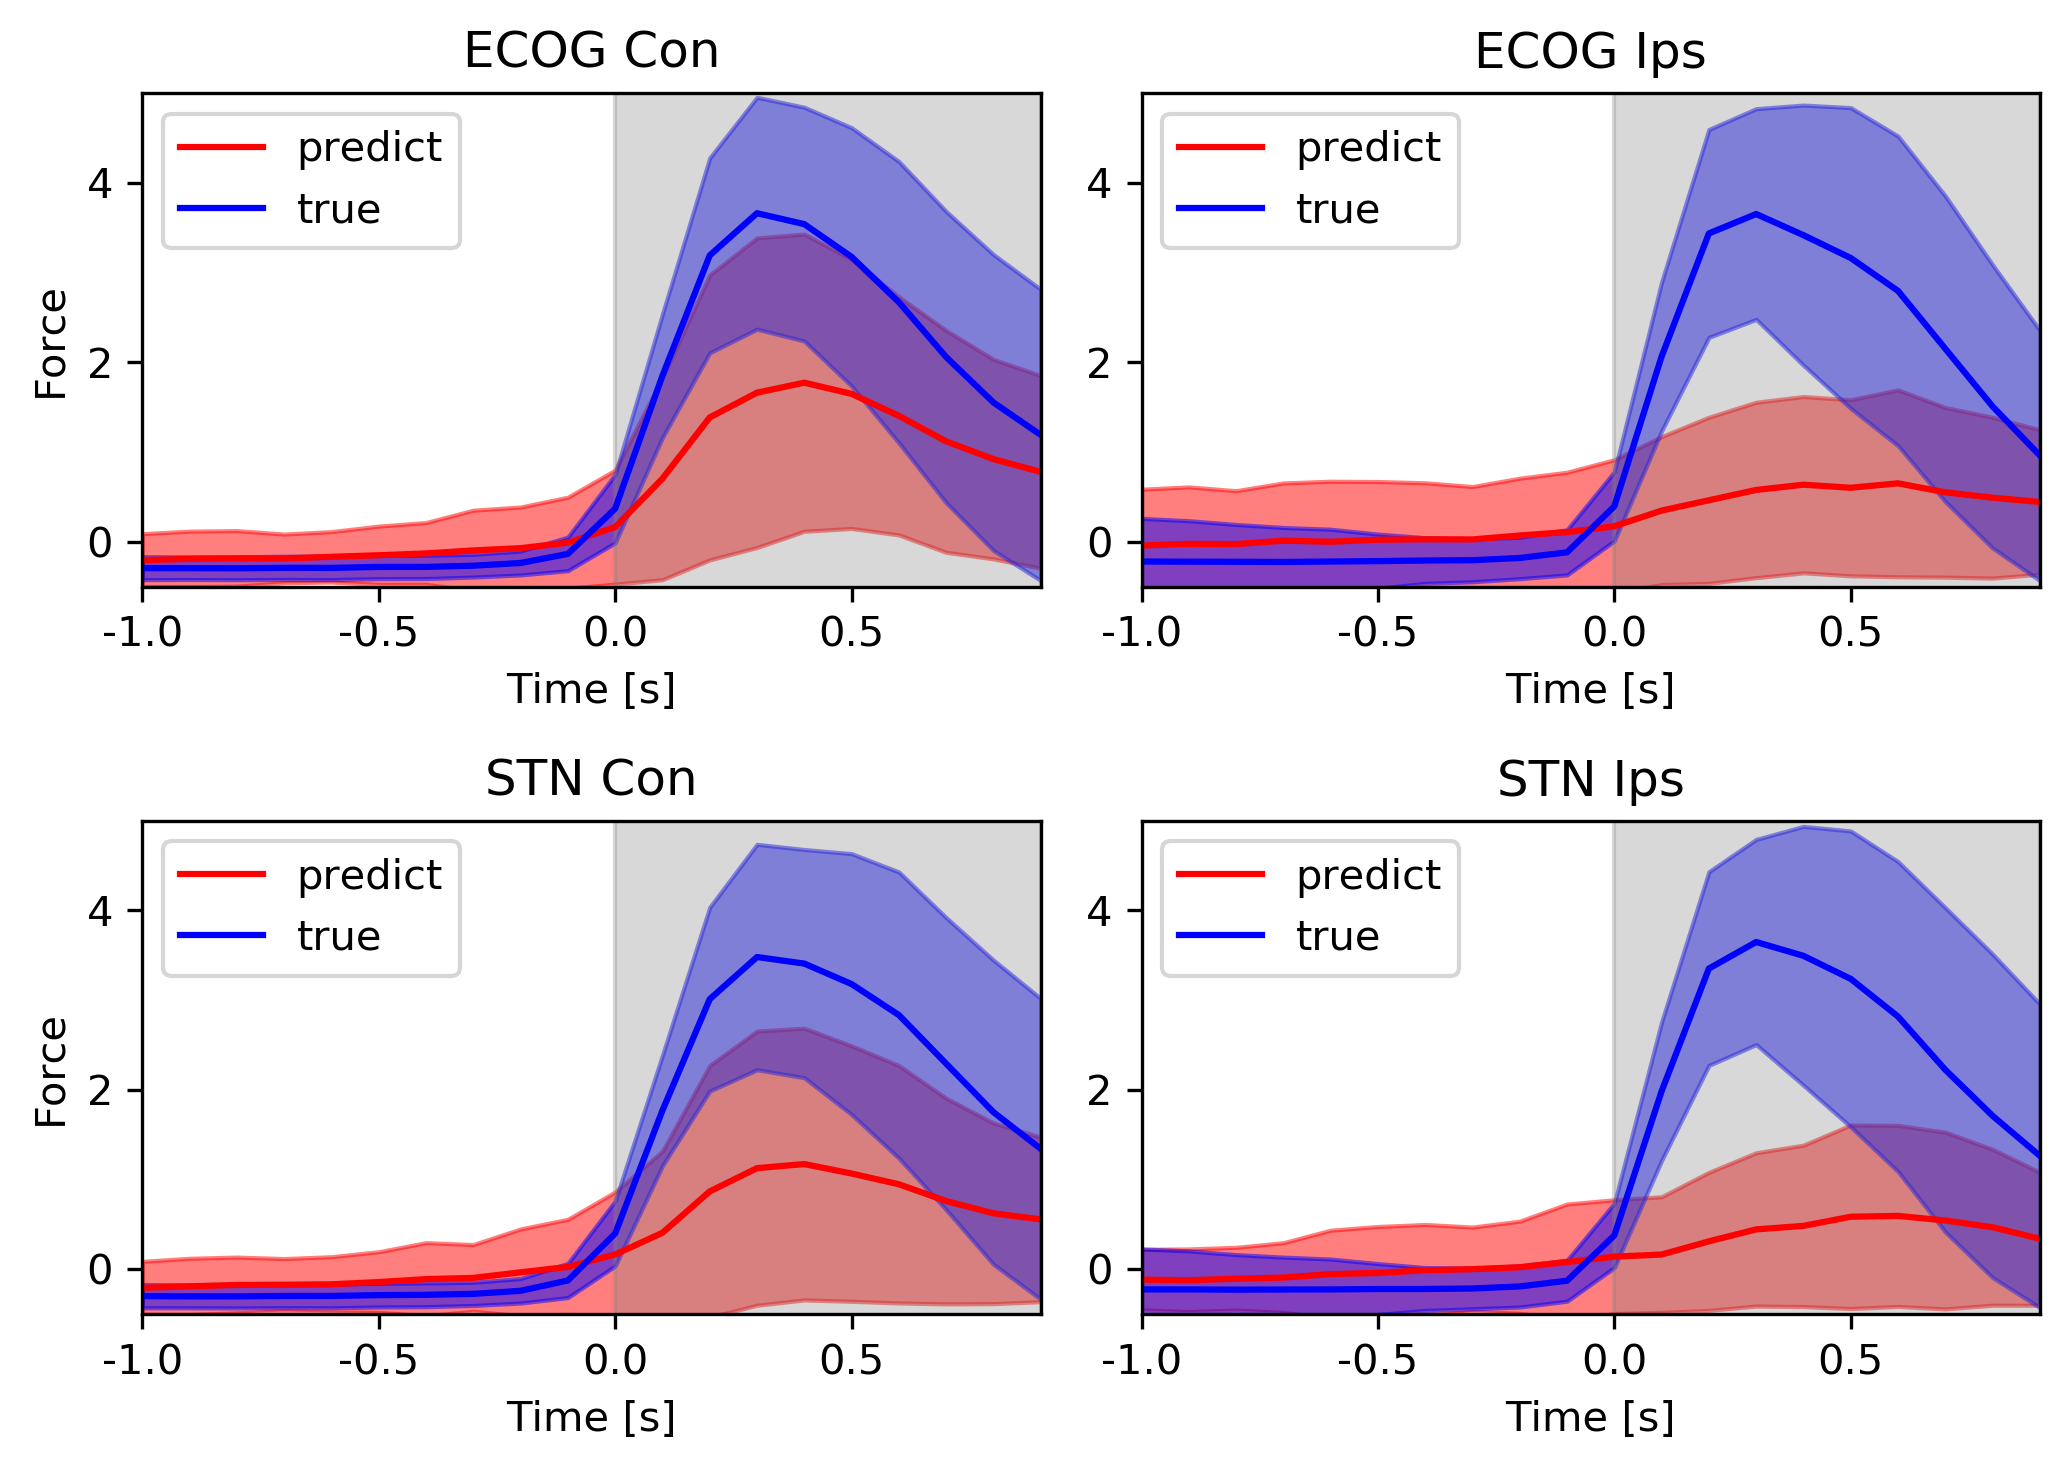

In [40]:
x = np.arange(20)
plt.figure(figsize=(7,5), dpi=300)
plt.subplot(2,2,1)
epoch_pr, epoch_true = get_concat_epochs(epochs_ecog_con)
plot_mov_epochs(epoch_pr, epoch_true, epoch_lim = 10)
arr = get_ttest(epochs_ecog_con)
plt.fill_between(x, -1,7, where=arr[x] <0.05, color='gray', alpha=0.3)
plt.title('ECOG Con'); plt.ylabel('Force'); plt.xlim(0,19)

plt.subplot(2,2,2)
epoch_pr, epoch_true = get_concat_epochs(epochs_ecog_ips)
plot_mov_epochs(epoch_pr, epoch_true, epoch_lim = 10)
arr = get_ttest(epochs_ecog_ips)
plt.fill_between(x, -1,7, where=arr[x] <0.05, color='gray', alpha=0.3)
plt.title('ECOG Ips'); plt.xlim(0,19)

plt.subplot(2,2,3)
epoch_pr, epoch_true = get_concat_epochs(epochs_stn_con)
plot_mov_epochs(epoch_pr, epoch_true, epoch_lim = 10)
arr = get_ttest(epochs_stn_con)
plt.fill_between(x, -1,7, where=arr[x] <0.05, color='gray', alpha=0.3)
plt.title('STN Con'); plt.ylabel('Force'); plt.xlim(0,19)

plt.subplot(2,2,4)
epoch_pr, epoch_true = get_concat_epochs(epochs_stn_ips)
plot_mov_epochs(epoch_pr, epoch_true, epoch_lim = 10)
arr = get_ttest(epochs_stn_ips)
plt.fill_between(x, -1,7, where=arr[x] <0.05, color='gray', alpha=0.3)
plt.title('STN Ips'); plt.xlim(0,19)
plt.tight_layout()

### examplary time plot revisited

In [20]:
subject_id_ = "000"
print(subject_id_)
#out_path = 'C:\\Users\\ICN_admin\\Documents\\Ubuntu_SAVE\\Documents\\raw_out\\LM_100ms\\'
out_path = 'C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\'
with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
    dict_ch = json.load(fp)

000


In [21]:
XGB_res["000"]["ECOG_RIGHT_1"]

{'r2_ips': 0.6138606666666666,
 'r2_con': 0.8196183333333332,
 'param_con': [40, 0.15149343663386153, 338, 6.8335468484607755],
 'param_ips': [40, 0.15149343663386153, 338, 6.8335468484607755]}

In [22]:
best_ch_STN_CON, _performance_STN_CON, _parameters_STN_CON = get_best_param(subject = "000", ECOG_ = False, CON_ = True)

In [23]:
best_ch_ECOG_CON, _performance_ECOG_CON, _parameters_ECOG_CON = get_best_param(subject = "000", ECOG_ = True, CON_ = True)

In [24]:
Con_ = True
best_param = _parameters_ECOG_CON#get_best_param(subject = subject_id_, ECOG_ = ECOG_, CON_ = Con_)[1]
print(best_param)
model_ = xgb.XGBRegressor(max_depth = int(best_param[0]), 
                  gamma = best_param[3],
              n_estimators = int(best_param[2]), 
            learning_rate = best_param[1], \
             subsample=0.8, eta=0.1, \
            disable_default_eval_metric=1)
mov_channels = dict_ch[best_ch_ECOG_CON]["mov_ch"]
mov_idx = get_movement_idx(best_ch_ECOG_CON, mov_channels, Con_)
mov_dat = np.array(dict_ch[best_ch_ECOG_CON]['true_movements'])[mov_idx,:]
X = np.array(dict_ch[best_ch_ECOG_CON]['data'])
X_train = X.T[2000:,:]; X_test = X.T[:2000,:]
y_train = mov_dat[2000:]; y_test = mov_dat[:2000]
#model_selection.train_test_split(X.T, mov_dat, test_size=0.33, shuffle=False)
X_train, y_train = append_time_dim(X_train, y_train, time_stamps=5)
X_test, y_test_ECOG_CON = append_time_dim(X_test, y_test, time_stamps=5)
model_.fit(X_train, y_train)
y_pred_ECOG_CON = model_.predict(X_test)


[40, 0.15149343663386153, 338, 6.8335468484607755]


In [26]:
Con_ = True
best_param = _parameters_STN_CON#get_best_param(subject = subject_id_, ECOG_ = ECOG_, CON_ = Con_)[1]
print(best_param)
model_ = xgb.XGBRegressor(max_depth = int(best_param[0]), 
                  gamma = best_param[3],
              n_estimators = int(best_param[2]), 
            learning_rate = best_param[1], \
             subsample=0.8, eta=0.1, \
            disable_default_eval_metric=1)

mov_channels = dict_ch[best_ch_STN_CON]["mov_ch"]
mov_idx = get_movement_idx(best_ch_STN_CON, mov_channels, Con_)
mov_dat = np.array(dict_ch[best_ch_STN_CON]['true_movements'])[mov_idx,:]
X = np.array(dict_ch[best_ch_STN_CON]['data'])
X_train = X.T[1000:,:]; X_test = X.T[:1000,:]
y_train = mov_dat[1000:]; y_test = mov_dat[:1000]
X_train, y_train = append_time_dim(X_train, y_train, time_stamps=5)
X_test, y_test_STN_CON = append_time_dim(X_test, y_test, time_stamps=5)
model_.fit(X_train, y_train)
y_pred_STN_CON = model_.predict(X_test)

[40, 0.15149343663386153, 338, 6.8335468484607755]


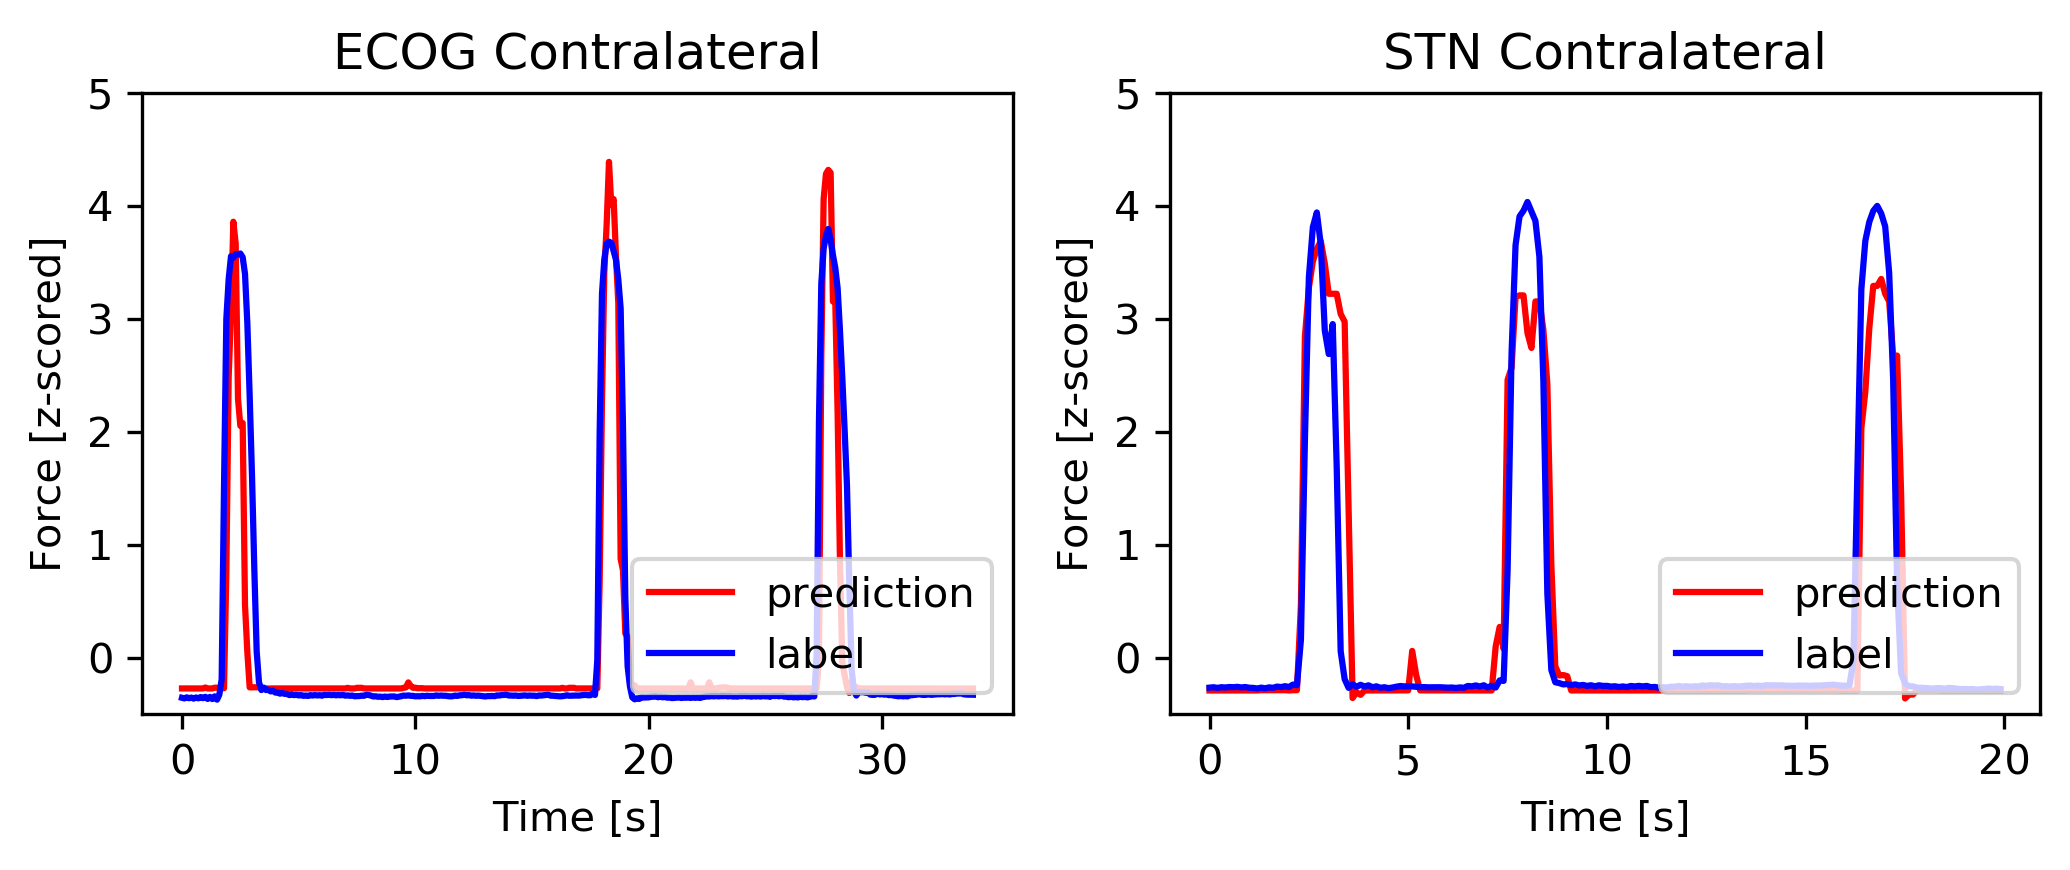

In [37]:
plt.figure(figsize=(7,3), dpi=300)
low_ = 700
high_ = 1040
x_ = np.arange(low_-low_, high_-low_)*0.1
plt.subplot(121)
plt.plot(x_, y_pred_ECOG_CON[low_:high_], label='prediction', color="red")
plt.plot(x_, y_test_ECOG_CON[low_:high_], label='label', color="blue")
plt.xlabel('Time [s]'); plt.ylabel('Force [z-scored]')
plt.title('ECOG Contralateral'); plt.legend(loc='lower right')
plt.ylim(-0.5,5)
plt.subplot(122)
low_ = 200
high_ = 400
x_ = np.arange(low_-low_, high_-low_)*0.1
plt.plot(x_, y_pred_STN_CON[low_:high_], label='prediction', color="red")
plt.plot(x_, y_test_STN_CON[low_:high_], label='label', color="blue")
plt.xlabel('Time [s]'); plt.ylabel('Force [z-scored]')
plt.title('STN Contralateral'); plt.legend(loc='lower right');plt.ylim(-0.5,5)
plt.tight_layout()

In [91]:
best_ch_ECOG_IPS, _performance_ECOG_IPS, _parameters_ECOG_IPS = get_best_param(subject = "000", ECOG_ = True, CON_ = False)

In [92]:
best_ch_STN_IPS, _performance_STN_IPS, _parameters_STN_IPS = get_best_param(subject = "000", ECOG_ = False, CON_ = False)

In [93]:
Con_ = False
best_param = _parameters_ECOG_IPS#get_best_param(subject = subject_id_, ECOG_ = ECOG_, CON_ = Con_)[1]
print(best_param)
model_ = xgb.XGBRegressor(max_depth = int(best_param[0]), 
                  gamma = best_param[3],
              n_estimators = int(best_param[2]), 
            learning_rate = best_param[1], \
             subsample=0.8, eta=0.1, \
            disable_default_eval_metric=1)
mov_channels = dict_ch[best_ch_ECOG_IPS]["mov_ch"]
mov_idx = get_movement_idx(best_ch_ECOG_IPS, mov_channels, Con_)
mov_dat = np.array(dict_ch[best_ch_ECOG_IPS]['true_movements'])[mov_idx,:]
X = np.array(dict_ch[best_ch_ECOG_IPS]['data'])
X_train = X.T[2000:,:]; X_test = X.T[:2000,:]
y_train = mov_dat[2000:]; y_test = mov_dat[:2000]
X_train, y_train = append_time_dim(X_train, y_train, time_stamps=5)
X_test, y_test_ECOG_IPS = append_time_dim(X_test, y_test, time_stamps=5)
model_.fit(X_train, y_train)
y_pred_ECOG_IPS = model_.predict(X_test)

[40, 0.15149343663386153, 338, 6.8335468484607755]


In [94]:
Con_ = False
best_param = _parameters_STN_IPS#get_best_param(subject = subject_id_, ECOG_ = ECOG_, CON_ = Con_)[1]
print(best_param)
model_ = xgb.XGBRegressor(max_depth = int(best_param[0]), 
                  gamma = best_param[3],
              n_estimators = int(best_param[2]), 
            learning_rate = best_param[1], \
             subsample=0.8, eta=0.1, \
            disable_default_eval_metric=1)
mov_channels = dict_ch[best_ch_STN_IPS]["mov_ch"]
mov_idx = get_movement_idx(best_ch_STN_IPS, mov_channels, Con_)
mov_dat = np.array(dict_ch[best_ch_STN_IPS]['true_movements'])[mov_idx,:]
X = np.array(dict_ch[best_ch_STN_IPS]['data'])
X_train = X.T[1000:,:]; X_test = X.T[:1000,:]
y_train = mov_dat[1000:]; y_test = mov_dat[:1000]
X_train, y_train_STN = append_time_dim(X_train, y_train, time_stamps=5)
X_test, y_test_STN_IPS = append_time_dim(X_test, y_test, time_stamps=5)
model_.fit(X_train, y_train_STN)
y_pred_STN_IPS = model_.predict(X_test)

[40, 0.15149343663386153, 338, 6.8335468484607755]


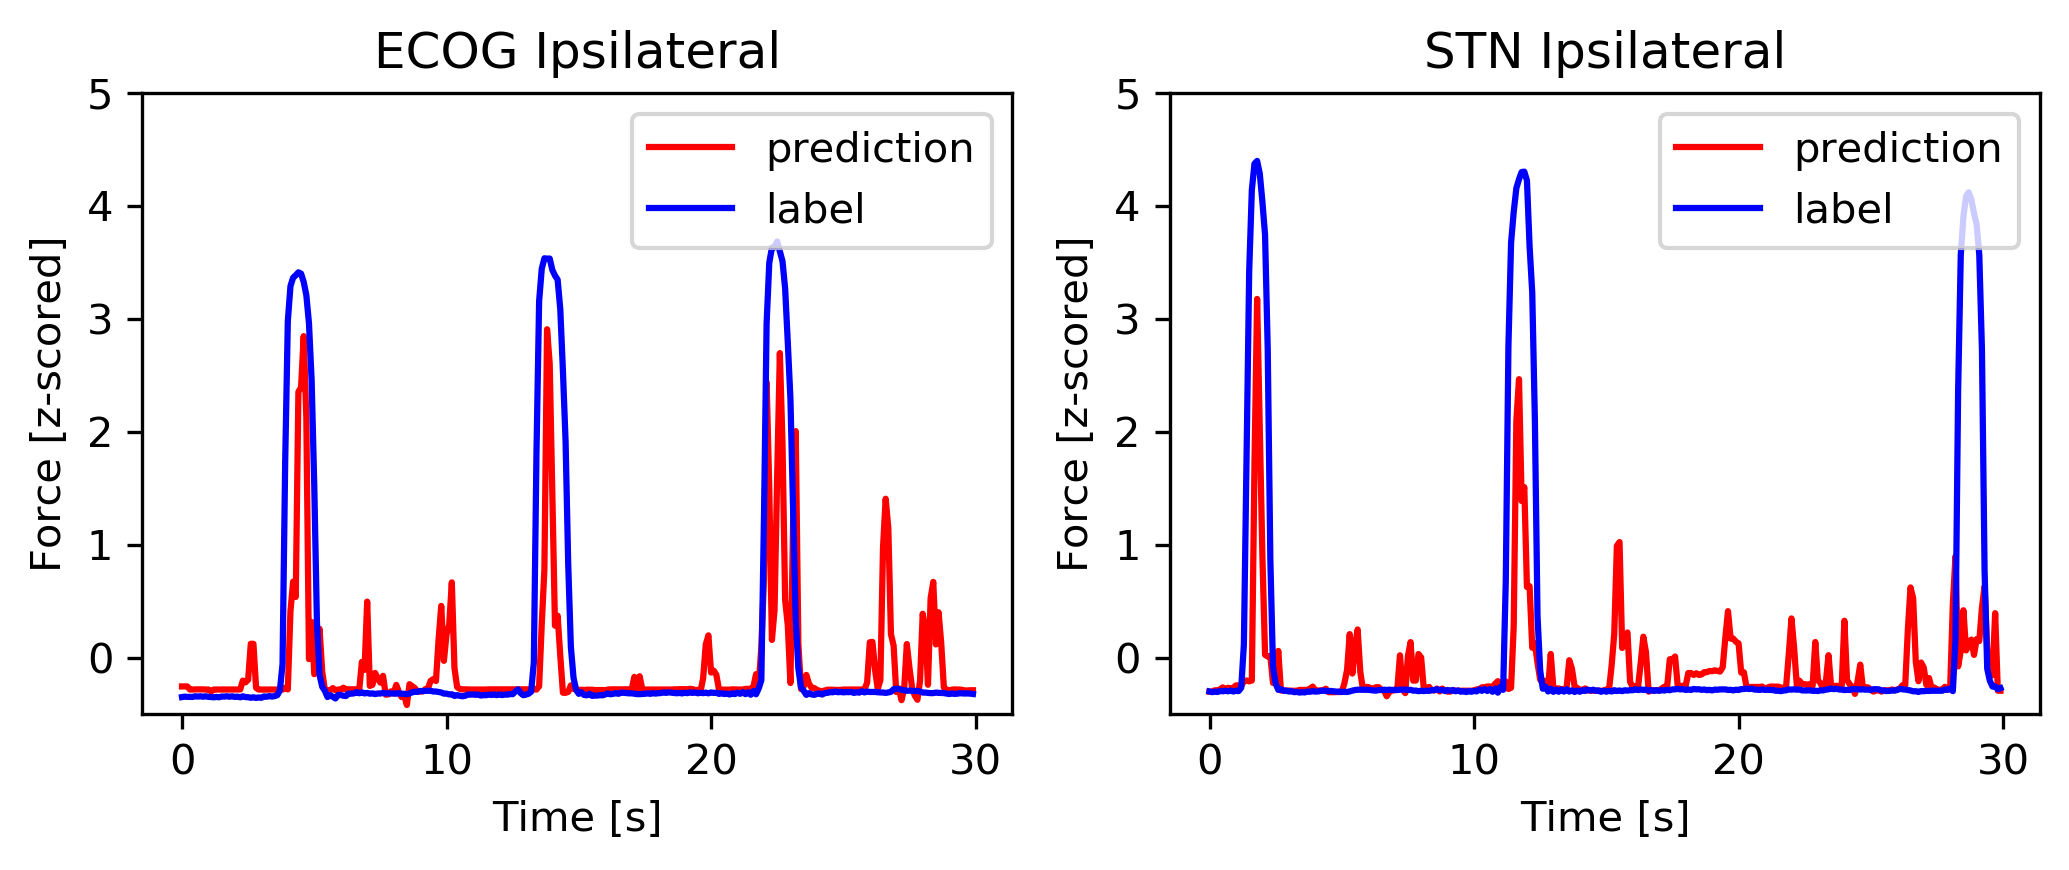

In [107]:
plt.figure(figsize=(7,3), dpi=300)
low_ = 450
high_ = 750
x_ = np.arange(low_-low_, high_-low_)*0.1
plt.subplot(121)
plt.plot(x_, y_pred_ECOG_IPS[low_:high_], label='prediction', color="red")
plt.plot(x_, y_test_ECOG_IPS[low_:high_], label='label', color="blue")
plt.xlabel('Time [s]'); plt.ylabel('Force [z-scored]')
plt.title('ECOG Ipsilateral'); plt.legend(loc='upper right')
plt.ylim(-0.5,5)
plt.subplot(122)
low_ = 400
high_ = 700
x_ = np.arange(low_-low_, high_-low_)*0.1
plt.plot(x_, y_pred_STN_IPS[low_:high_], label='prediction', color="red")
plt.plot(x_, y_test_STN_IPS[low_:high_], label='label', color="blue")
plt.xlabel('Time [s]'); plt.ylabel('Force [z-scored]')
plt.title('STN Ipsilateral'); plt.legend(loc='upper right');plt.ylim(-0.5,5)
plt.tight_layout()

### examplary different time plot

In [89]:
subject = "004"
ECOG_ = False
CON_= True

channels = list(XGB_res[subject].keys())
perf_sub = []
reg_sub = []
channels_used = []
for ch in channels:
    if (ECOG_ is True and 'STN' in ch) or (ECOG_ is False and 'ECOG' in ch):
        continue
    if CON_ is True:
        perf_sub.append(XGB_res[subject][ch]['r2_con'])
        reg_sub.append(XGB_res[subject][ch]['param_con'])
    else:
        perf_sub.append(XGB_res[subject][ch]['r2_ips'])
        reg_sub.append(XGB_res[subject][ch]['param_ips'])
    channels_used.append(ch)

#return channels[np.argmax(perf_sub)], perf_sub[np.argmax(perf_sub)], reg_sub[np.argmax(perf_sub)]

In [91]:
channels

['ECOG_RIGHT_0',
 'ECOG_RIGHT_1',
 'ECOG_RIGHT_2',
 'ECOG_RIGHT_3',
 'ECOG_RIGHT_4',
 'ECOG_RIGHT_5',
 'ECOG_RIGHT_6',
 'ECOG_RIGHT_7',
 'STN_RIGHT_0',
 'STN_RIGHT_1',
 'STN_RIGHT_2',
 'STN_RIGHT_3',
 'ECOG_LEFT_0',
 'ECOG_LEFT_1',
 'ECOG_LEFT_2',
 'ECOG_LEFT_3',
 'ECOG_LEFT_4',
 'ECOG_LEFT_5',
 'ECOG_LEFT_6',
 'ECOG_LEFT_7',
 'STN_LEFT_0',
 'STN_LEFT_1',
 'STN_LEFT_2',
 'STN_LEFT_3']

In [328]:
subject_id_ = "008"
print(subject_id_)
#out_path = 'C:\\Users\\ICN_admin\\Documents\\Ubuntu_SAVE\\Documents\\raw_out\\LM_100ms\\'
out_path = 'C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\'
with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
    dict_ch = json.load(fp)

008


In [329]:
best_ch_ECOG_CON, _performance_ECOG_CON, _parameters_ECOG_CON = get_best_param(subject = subject_id_, ECOG_ = True, CON_ = True)
print(best_ch_ECOG_CON)
print(_performance_ECOG_CON)

ECOG_LEFT_2
0.6077083333333334


In [330]:
best_ch_ECOG_IPS, _performance_ECOG_IPS, _parameters_ECOG_IPS = get_best_param(subject = subject_id_, ECOG_ = True, CON_ = False)
print(best_ch_ECOG_IPS)
print(_performance_ECOG_IPS)

ECOG_LEFT_0
0.16118666666666667


In [331]:
best_ch_STN_CON, _performance_STN_CON, _parameters_STN_CON = get_best_param(subject = subject_id_, ECOG_ = False, CON_ = True)
print(best_ch_STN_CON)
print(_performance_STN_CON)

STN_LEFT_1
0.22892466666666667


In [332]:
best_ch_STN_IPS, _performance_STN_IPS, _parameters_STN_IPS = get_best_param(subject = subject_id_, ECOG_ = False, CON_ = False)
print(best_ch_STN_IPS)
print(_performance_STN_IPS)

STN_LEFT_1
0.10226433333333335


In [355]:
### train ECOG CON 
Con_ = True
best_param = _parameters_ECOG_CON#get_best_param(subject = subject_id_, ECOG_ = ECOG_, CON_ = Con_)[1]
print(best_param)
model_ = xgb.XGBRegressor(max_depth = int(best_param[0]), 
                  gamma = best_param[3],
              n_estimators = int(best_param[2]), 
            learning_rate = best_param[1], \
             subsample=0.8, eta=0.1, \
            disable_default_eval_metric=1)
mov_channels = dict_ch[best_ch_ECOG_CON]["mov_ch"]
mov_idx = get_movement_idx(best_ch_ECOG_CON, mov_channels, Con_)
mov_dat = np.array(dict_ch[best_ch_ECOG_CON]['true_movements'])[mov_idx,:]
X = np.array(dict_ch[best_ch_ECOG_CON]['data'])
X_train = X.T[2000:,:]; X_test = X.T[:2000,:]
y_train = mov_dat[2000:]; y_test = mov_dat[:2000]
#model_selection.train_test_split(X.T, mov_dat, test_size=0.33, shuffle=False)
X_train, y_train = append_time_dim(X_train, y_train, time_stamps=5)
X_test, y_test_ECOG_CON = append_time_dim(X_test, y_test, time_stamps=5)
model_.fit(X_train, y_train)
y_pred_ECOG_CON = model_.predict(X_test)

Con_ = False
best_param = _parameters_ECOG_IPS#get_best_param(subject = subject_id_, ECOG_ = ECOG_, CON_ = Con_)[1]
print(best_param)
model_ = xgb.XGBRegressor(max_depth = int(best_param[0]), 
                  gamma = best_param[3],
              n_estimators = int(best_param[2]), 
            learning_rate = best_param[1], \
             subsample=0.8, eta=0.1, \
            disable_default_eval_metric=1)
mov_channels = dict_ch[best_ch_ECOG_IPS]["mov_ch"]
mov_idx = get_movement_idx(best_ch_ECOG_IPS, mov_channels, Con_)
mov_dat = np.array(dict_ch[best_ch_ECOG_IPS]['true_movements'])[mov_idx,:]
X = np.array(dict_ch[best_ch_ECOG_IPS]['data'])
X_train = X.T[2000:,:]; X_test = X.T[:2000,:]
y_train = mov_dat[2000:]; y_test = mov_dat[:2000]
X_train, y_train = append_time_dim(X_train, y_train, time_stamps=5)
X_test, y_test_ECOG_IPS = append_time_dim(X_test, y_test, time_stamps=5)
model_.fit(X_train, y_train)
y_pred_ECOG_IPS = model_.predict(X_test)

Con_ = True
best_param = _parameters_STN_CON#get_best_param(subject = subject_id_, ECOG_ = ECOG_, CON_ = Con_)[1]
print(best_param)
model_ = xgb.XGBRegressor(max_depth = int(best_param[0]), 
                  gamma = best_param[3],
              n_estimators = int(best_param[2]), 
            learning_rate = best_param[1], \
             subsample=0.8, eta=0.1, \
            disable_default_eval_metric=1)

mov_channels = dict_ch[best_ch_STN_CON]["mov_ch"]
mov_idx = get_movement_idx(best_ch_STN_CON, mov_channels, Con_)
mov_dat = np.array(dict_ch[best_ch_STN_CON]['true_movements'])[mov_idx,:]
X = np.array(dict_ch[best_ch_STN_CON]['data'])
X_train = X.T[1000:,:]; X_test = X.T[:1000,:]
y_train = mov_dat[1000:]; y_test = mov_dat[:1000]
X_train, y_train = append_time_dim(X_train, y_train, time_stamps=5)
X_test, y_test_STN_CON = append_time_dim(X_test, y_test, time_stamps=5)
model_.fit(X_train, y_train)
y_pred_STN_CON = model_.predict(X_test)

Con_ = False
best_param = _parameters_STN_IPS#get_best_param(subject = subject_id_, ECOG_ = ECOG_, CON_ = Con_)[1]
print(best_param)
model_ = xgb.XGBRegressor(max_depth = int(best_param[0]), 
                  gamma = best_param[3],
              n_estimators = int(best_param[2]), 
            learning_rate = best_param[1], \
             subsample=0.8, eta=0.1, \
            disable_default_eval_metric=1)
mov_channels = dict_ch[best_ch_STN_IPS]["mov_ch"]
mov_idx = get_movement_idx(best_ch_STN_IPS, mov_channels, Con_)
mov_dat = np.array(dict_ch[best_ch_STN_IPS]['true_movements'])[mov_idx,:]
X = np.array(dict_ch[best_ch_STN_IPS]['data'])
X_train = X.T[1000:,:]; X_test = X.T[:1000,:]
y_train = mov_dat[1000:]; y_test = mov_dat[:1000]
X_train, y_train_STN = append_time_dim(X_train, y_train, time_stamps=5)
X_test, y_test_STN_IPS = append_time_dim(X_test, y_test, time_stamps=5)
model_.fit(X_train, y_train_STN)
y_pred_STN_IPS = model_.predict(X_test)

[60, 0.16646722614124754, 858, 8.62526564905713]
[40, 0.15149343663386153, 338, 6.8335468484607755]
[40, 0.15149343663386153, 338, 6.8335468484607755]
[48, 0.10105405843110161, 521, 7.109915771070644]


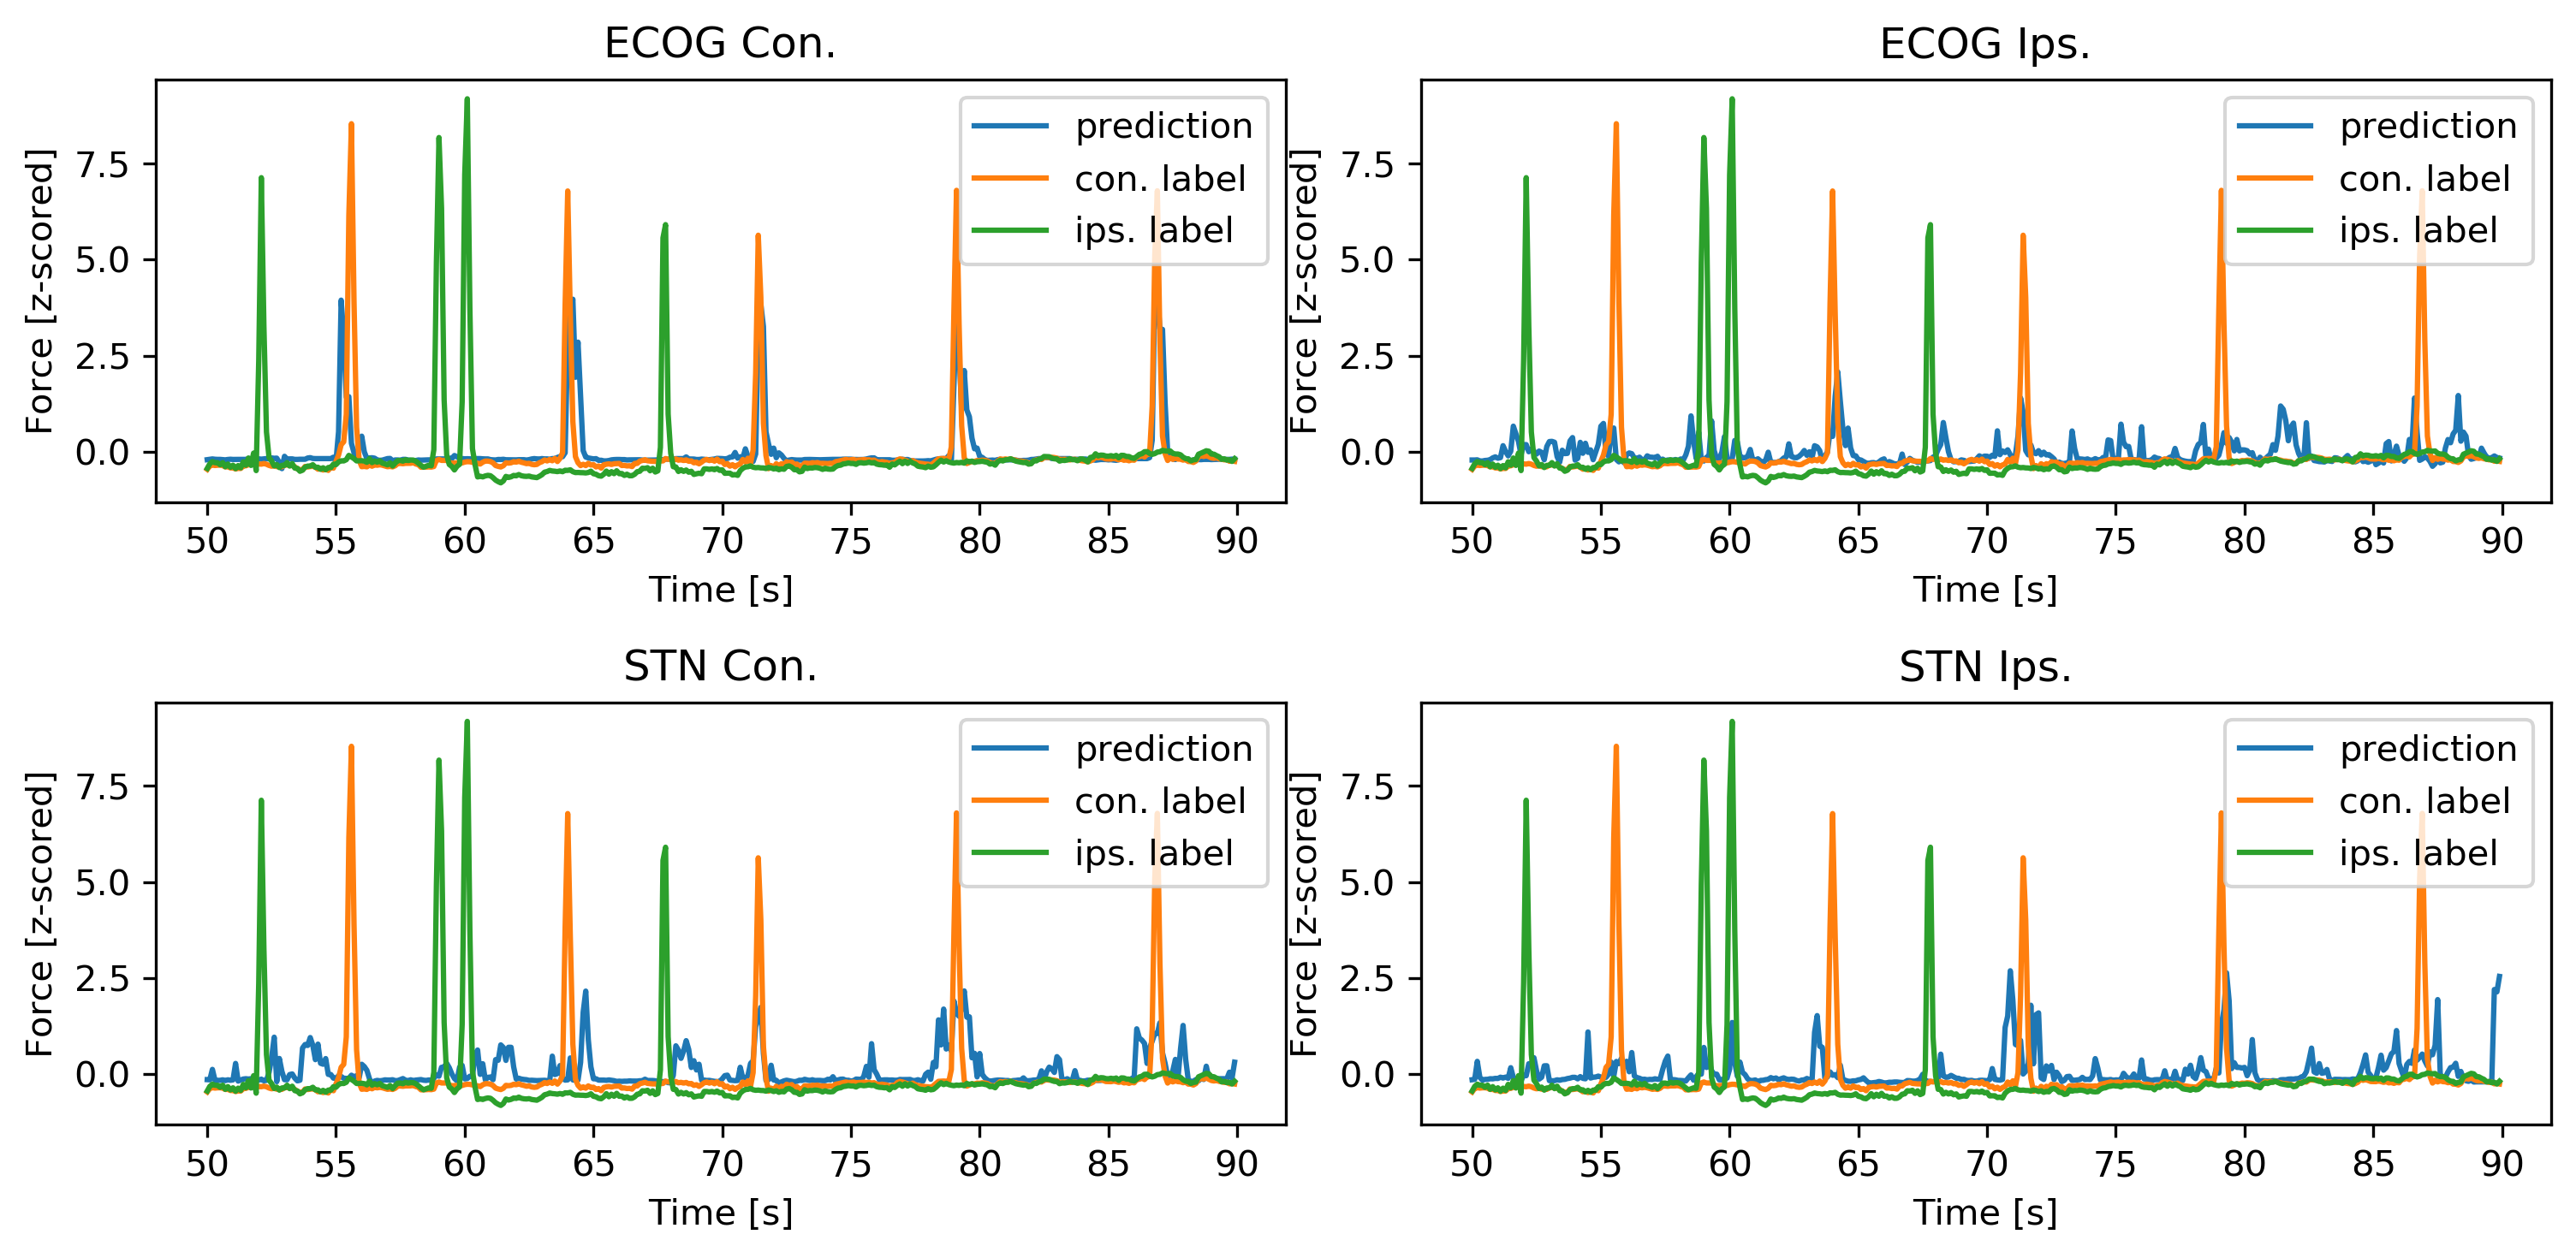

In [375]:
low_ECOG_CON = 500; high_ECOG_CON =900
low_ = low_ECOG_CON # others
high_ = high_ECOG_CON
x_ecog_con = np.arange(low_ECOG_CON, high_ECOG_CON)*0.1
x_ = np.arange(low_, high_)*0.1
plt.figure(figsize=(10,5), dpi=300)
plt.subplot(221)
plt.plot(x_ecog_con, y_pred_ECOG_CON[low_ECOG_CON:high_ECOG_CON], label='prediction')
plt.plot(x_ecog_con, y_test_ECOG_CON[low_ECOG_CON:high_ECOG_CON], label='con. label')
plt.plot(x_, y_test_ECOG_IPS[low_:high_], label='ips. label')
plt.xlabel('Time [s]'); plt.ylabel('Force [z-scored]')
plt.title('ECOG Con.'); plt.legend(loc='upper right')

plt.subplot(222)
plt.plot(x_, y_pred_ECOG_IPS[low_:high_], label='prediction')
plt.plot(x_ecog_con, y_test_ECOG_CON[low_ECOG_CON:high_ECOG_CON], label='con. label')
plt.plot(x_, y_test_ECOG_IPS[low_:high_], label='ips. label')
plt.xlabel('Time [s]'); plt.ylabel('Force [z-scored]')
plt.title('ECOG Ips.'); plt.legend(loc='upper right')

plt.subplot(223)
plt.plot(x_, y_pred_STN_CON[low_:high_], label='prediction')
plt.plot(x_, y_test_STN_CON[low_:high_], label='con. label')
plt.plot(x_, y_test_STN_IPS[low_:high_], label='ips. label')
plt.xlabel('Time [s]'); plt.ylabel('Force [z-scored]')
plt.title('STN Con.'); plt.legend(loc='upper right')

plt.subplot(224)
plt.plot(x_, y_pred_STN_IPS[low_:high_], label='prediction')
plt.plot(x_, y_test_STN_CON[low_:high_], label='con. label')
plt.plot(x_, y_test_STN_IPS[low_:high_], label='ips. label')
plt.xlabel('Time [s]'); plt.ylabel('Force [z-scored]')
plt.title('STN Ips.'); plt.legend(loc='upper right')
plt.tight_layout()